# **Counterexample for Gal's conjecture**
***
***

## Description

**<ins>Gal's conjecture:</ins>** Let $\Delta$ be a simplicial complex. If $\Delta$ is flag simplicial (homology) sphere, then $\gamma(\Delta)$ is nonnegative.

**<ins>Notions:</ins>**

- A simplicial complex $\Delta$ called *flag*, if all minimal non-faces of $\Delta$ are of size $2$. 
- A simplicial complex $\Delta$ called *simplicial sphere*, if $\Delta$ triangulates a ($\dim(\Delta)$)-sphere.
- More generally a simplicial complex $\Delta$ called *homology sphere*, if for every face $F\in\Delta$, $\text{lk}_\Delta(F)$ has the same homology as a ($\dim(\text{lk}_\Delta(F)$)-sphere.

**<ins>Known results:</ins>** 

- In order to be a simplicial (homology) sphere, the $h$-vector has to be symmetric. 
- The conjecture is proven for dimension $3$ and $4$.

**<ins>Goal:</ins>** At the moment we try to find a counterexample for the homology sphere case in dimension $5$.

**<ins>Approach:</ins>**

- Consider a graph and construct it's corresponding clique complex.
- Compute: $f$-vector ------> $h$-vector ------> $\gamma$-vector.
- First: teaching the machine to only generate $h$-vectors of length $7$.
- Second: teaching the machine to only consider those $h$-vectors from above which are symmetric.
- Third: from the above two conditions of the $h$-vector, try teaching the machine to find a $\gamma$-vector with negative entries.

## Inputs

In [1]:
import networkx as nx
import random
import numpy as np
from numpy.linalg import matrix_power
from statistics import mean
from collections import Counter
import math
import matplotlib.pyplot as plt
import torch
from torch import nn
from cached_method import cached_method
import time

## The model

In [34]:
N = 17  # Number of vertices in the graph.
M = N*(N-1)//2  # Number of edges in the graph.
punish_value = 100000000

class MYModel(nn.Module):
    def __init__(self, layer_dims):
        super().__init__()

        # Deal with the state and one-hot move vectors separately, since we can do this efficiently.
        self.first_state = nn.Linear(M, layer_dims[0])
        self.first_move = nn.Linear(M, layer_dims[0], bias=False)

        self.layers = nn.ModuleList([
            nn.Linear(a, b)
            for a, b in zip(layer_dims, layer_dims[1:])
        ])

        self.fully_conn = nn.Linear(layer_dims[-1], 1)

    def forward(self, state, move):
        x = self.first_state(state) + self.first_move(move)
        x = nn.functional.relu(x)

        for linear in self.layers:
            x = linear(x)
            x = nn.functional.relu(x)

        x = self.fully_conn(x)
        x = torch.sigmoid(x)
        return x

## Helper functions

In [35]:
def board_to_adj(board):
    """
    Input: A tensor of shape (*, M), giving a (batched) 01-sequence of edges.
    Output: A tensor of shape (*, N, N), giving a (batched) adjacency matrix.
    """
    adj = np.zeros([*board.shape[:-1], N, N], dtype=np.int8)
    count = 0
    for i in range(N):
        for j in range(i+1, N):
            adj[..., i, j] = adj[..., j, i] = board[..., count] != 0
            count += 1

    return adj

def display_adj(adj):
    #print(adj)
    G = nx.convert_matrix.from_numpy_array(adj)
    plt.clf()
    plt.axis('equal')
    nx.draw_circular(nx.complement(G))
    plt.savefig("mygraph.png")

### Compute $f$-vector, $h$-vector and $\gamma$-vector

In [36]:
def f_vector(adj):
    G = nx.convert_matrix.from_numpy_array(adj)
    cliques = list(nx.enumerate_all_cliques(G))
    faces_count = Counter([len(elm) for elm in cliques])
    f_vec = [faces_count[i] for i in range(len(faces_count)+1)]
    f_vec[0] = 1
    return f_vec, cliques
    """
    d = max(list_faces_and_count)[0]
    f_vec = [(pair[1]) for pair in list_faces_and_count]
    f_vec.insert(0,1)
    return f_vec
    if cliques == True:
        return f_vec, d, list_of_all_cliques
    else:
        return f_vec, d
    """

def h_vector(f_vec):
    h_vec = []
    d = len(f_vec)-1

    for k in range(d+1):
        h_k = 0
        for i in range(k+1):
            h_k += (-1)**(k-i)*math.comb(d-i,k-i)*f_vec[i]
        h_vec.append(h_k)
    
    return h_vec

def h_vector_from_simplices(all_faces):
    faces_count = Counter([len(elm) for elm in all_faces])
    f_vec = [faces_count[i] for i in range(len(faces_count)+1)]
    f_vec[0] = 1

    return h_vector(f_vec)

def is_symmetric(h_vec):
    d = len(h_vec)
    split_index = (len(h_vec)-1)//2
    is_symm = True
    
    if d % 2 != 0:
        for i in range(split_index):
            if h_vec[i] == h_vec[-(i+1)]:
                continue
            else:
                is_symm = False
                break
    elif d % 2 == 0:
        for i in range(split_index+1):
            if h_vec[i] == h_vec[-(i+1)]:
                continue
            else:
                is_symm = False
                break
    
    return is_symm

def gamma_vector(h_vec):
    gam_vec = []
    n = len(h_vec)-1
    d = n//2

    # gamma 0
    gam_vec.append(h_vec[0])

    # gamma 1 to d
    for i in range(1,d+1):
        g_k = h_vec[i]
        for j in range(i):
            g_k -= math.comb(n-2*j,i-j)*gam_vec[j]
        gam_vec.append(g_k)

    return gam_vec

def link(cliques,face):
    face = np.array(face)
    link_li = []

    for elm in cliques:
        if elm != list(face):
            inters = list(np.intersect1d(face, np.array(elm)))
            if len(inters)==0:
                union = list(np.union1d(face,elm))
                if union in cliques:
                    link_li.append(elm)
    
    return link_li

start = time.time()
adj = np.array([[0,1,1,0],
                [1,0,0,1],
                [1,0,0,1],
                [0,1,1,0]])
f_vec, cliques = f_vector(adj)
s = link(cliques,[1])
hvec = h_vector_from_simplices(s)
end = time.time()
print(end-start,hvec,s)

0.0026361942291259766 [1, 1] [[0], [3]]


### Games and learning

In [37]:
def play_games(agent, k_games):
    """
    Play k_games using the agent to give probability distributions on each move.
    """

    board = np.zeros((k_games, M), dtype=np.float32)
    moveid = torch.eye(M)

    for step in range(M):
        if step >= M-15:
          board[:, step] = np.ones(k_games)
        else:
          with torch.no_grad():
            prob = agent(torch.from_numpy(board), moveid[step:step+1, :]).view(k_games).numpy()

          board[:, step] = np.random.rand(k_games) < prob

    return board

In [38]:
def reinforce_games(
    model,
    optimiser,
    games,           # (n_games, M)
    batch_size=90,
):
    """
    Given a list of completed games, reinforce each move in each game.
    """
    n_games, _ = games.shape
    #moveid = torch.eye(M)

    # Unpack the games into (state, move, actions).
    states = torch.zeros((n_games, M, M))
    moveids = torch.zeros((n_games, M, M))
    actions = torch.zeros((n_games, M, 1))
    for t in range(M):
        moveids[:, t, t] = 1
        states[:, t+1:, t] = torch.from_numpy(games[:, None, t])
        actions[:, t, 0] = torch.from_numpy(games[:, t])

    # Reshape these so that we can shuffle the moves between games.
    states = states.flatten(end_dim=1)
    moveids = moveids.flatten(end_dim=1)
    actions = actions.flatten(end_dim=1)

    # Reinforce
    criterion = nn.BCELoss()
    shuffle = torch.randperm(n_games * M)
    for i in range(0, n_games * M, batch_size):
        batch = shuffle[i:i+batch_size]

        optimiser.zero_grad()
        predicted = model(states[batch], moveids[batch])
        loss = criterion(predicted, actions[batch])
        loss.backward()
        optimiser.step()

## Score function and Hyperparameter

In [39]:
# Number of new games to play each round.
K_GAMES = 500

# Create a fresh network, and specify its architecture.
model = MYModel([50, 40, 30])                                                                ## originally: [32, 12, 4]

# The learning rate should be increased if convergence is too slow, but decreased if
# the algorithm keeps getting stuck in local minima.
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)                                  ## originally: torch.optim.Adam, lr=0.0009

# The percentage of K_GAMES to reinforce.
KEEP_TOP = int(round(K_GAMES * 0.1))

# The scoring function to use
def score_fn(adj):

    # Check if graph is connected
    #conn = Main.check_connected(adj)
    
    if np.sum(adj) < N: #or np.sum(adj) > 26:
        return punish_value
    else:
        G = nx.convert_matrix.from_numpy_array(adj)
        if nx.node_connectivity(G) == 0:
            return int(punish_value/2)
        if nx.node_connectivity(G) == 1:
            return int(punish_value/4)
        if nx.node_connectivity(G) == 2:
            return int(punish_value/5)
        
        f_vec, cliques = f_vector(adj)

        if len(f_vec) > 9:
            return  int(punish_value/5)
        else:
            h_vec = h_vector(f_vec)
            
            d = len(h_vec)-1
            neg_components = abs(sum([h for h in h_vec if h < 0]))

            if neg_components > 0:
                return neg_components*10000

            if d+1 == 7:
                t = sum([abs(h_vec[d-i]-h_vec[i]) for i in range(d//2+1)])
                if t > 0:
                    return 100*t
                elif t == 0:
                    gam_vec = gamma_vector(h_vec)
                    gam_min = min(gam_vec)
                    #return gam_min
                
                    if gam_min < 0:
                        considered_cliques = [x for x in cliques if len(x)==d-1 or len(x)==d-2]
                        for face in considered_cliques:
                            l = link(cliques,face)
                            l_h_vec = h_vector_from_simplices(l)
                            l_d = len(l_h_vec)-1
                            l_t = sum([abs(l_h_vec[l_d-i]-l_h_vec[i]) for i in range(l_d//2+1)])
                            if l_t > 0:
                                gam_min += l_t
                            elif l_t == 0:
                                continue
                        return gam_min 
                    else:
                        return gam_min + 100
            else:
                return neg_components + 10000

## Run the process

In [40]:
# This cell can be re-run without resetting the model. 
top_games = np.ones((0, M), dtype=np.float32)

collection = []

def run():
    # Keep only the top so many games here.
    global top_games
    global collection
    for i in range(201):
        # Play some new games.
        new_games = play_games(model, K_GAMES)

        # Mix these games into our pot of the best games so far.
        games = np.concatenate([top_games, new_games], axis=0)

        # Score the games, and rearrange into descending order by score.
        scores = []
        for game in games:
            adj = board_to_adj(game)
            score = score_fn(adj)
            scores.append(score)
        
        scores = np.array(scores).astype(int)
        order = np.argsort(scores)[:KEEP_TOP]
        top_games = games[order]
        
        # Train
        reinforce_games(model, optimiser, top_games, batch_size=90)

        # Display progress
        if i % 10 == 0:
            top_adj = board_to_adj(top_games[:3])
            print("-------------------------")
            print("-------------------------")
            print("Round: ",i)
            print("-------------------------")
            for game in top_adj:
                score=score_fn(game)
                hvec=h_vector(f_vector(game)[0])
                gamvec = gamma_vector(hvec)
                print(f"Scores: {score}")
                print(f"h-vec: {hvec}")
                print(f"gam-vec: {gamvec}")
                if score == min(gamvec):
                    collection.append(game)
            display_adj(board_to_adj(top_games[0]))

    print(board_to_adj(top_games[0]))

In [ ]:
run()

## Visualize the results

In [ ]:
# new_collec = np.unique(collection,axis=0)
# new_collec[1]

In [ ]:
adj = new_collec[1]
h_vector(f_vector(adj)[0]), gamma_vector(h_vector(f_vector(adj)[0]))

NameError: name 'new_collec' is not defined

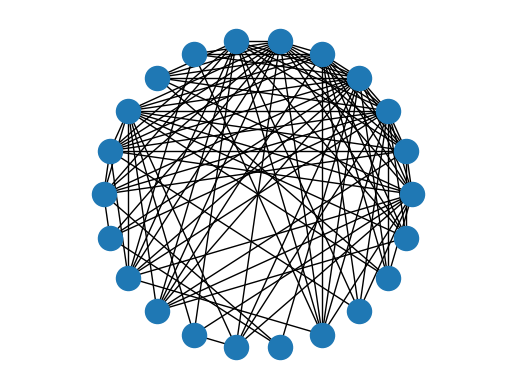

In [ ]:
display_adj(adj)

In [ ]:
g = nx.convert_matrix.from_numpy_array(adj)
#[x for x in list(nx.enumerate_all_cliques(g)) if len(x)>=6]
max(list(nx.find_cliques(g)))

[17, 18, 20, 16, 19, 21]

## Checking homology sphere condition

In [ ]:
def clique_condition(adj,dim): # dim is simplicial-complex dimension
    holds = True

    # Create graph and compute the necessary cliques
    g = nx.convert_matrix.from_numpy_array(adj)
    cliques = list(nx.enumerate_all_cliques(g))
    biggest_cliques = [x for x in cliques if len(x)==dim+1]
    second_biggest_cliques = [x for x in cliques if len(x)==dim]

    # Checking the condition
    for elm1 in second_biggest_cliques:
        count = 0
        for elm2 in biggest_cliques:
            if set(elm1).issubset(set(elm2)):
                count +=1
            else:
                continue
        if count == 2:
            #print("I'm here")
            continue
        else:
            holds = False
            break

    return holds

In [ ]:
adj = new_collec[0]

clique_condition(adj,5)

False